In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seawater as sw
import cmocean
import matplotlib.patches as patches
import cartopy.crs as ccrs
from matplotlib.offsetbox import AnchoredText
import xorca_brokenline as bl
import string
import warnings

warnings.filterwarnings("ignore")

In [2]:
def depth_weighted_mean(S_T_thresh, dim=None):
    diff_z = np.diff(S_T_thresh.deptht)
    dz = np.insert(diff_z, 0, diff_z.mean())
    mask = xr.where(S_T_thresh > -50, 1, np.nan)
    dz_masked = dz[None, :, None, None] * mask
    dz_sum_masked = dz_masked.sum(dim="deptht")
    # making mask of ones and nans -- mask changes per year (ones and nans) since depth changes per year
    weighted_depth_mean = (S_T_thresh * dz_masked).sum(
        dim="deptht"
    ).squeeze() / dz_sum_masked
    # weighted_depth_mean_ts = weighted_depth_mean.mean(dim=dim)
    return weighted_depth_mean


def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return fit, da - fit


def select_data(data):
    north_sel = data.isel(y=slice(300, None), x=slice(300, None))
    return north_sel

## Figure 1


In [3]:
inpath = "/gxfs_work/geomar/smomw452/GLORYS12/Data/"
mesh_mask = xr.open_dataset(inpath + "mesh_masks/combined_mesh_mask.nc")
bathy = mesh_mask.hdept.isel(t=0)
land_mask = mesh_mask.tmaskutil.isel(t=0).where(mesh_mask.tmaskutil.isel(t=0) != 0)
lon, lat = mesh_mask.nav_lon, mesh_mask.nav_lat

ds_U = xr.open_mfdataset(inpath + "U_monthly/*.nc", combine="by_coords").vozocrtx
ds_V = xr.open_mfdataset(inpath + "V_monthly/*.nc", combine="by_coords").vomecrty

In [4]:
U = select_data(ds_U)
V = select_data(ds_V)

U_600_1300m_mean = depth_weighted_mean(U.sel(deptht=slice(600, 1300)))

V_600_1300m_mean = depth_weighted_mean(V.sel(deptht=slice(600, 1300)))

speed = np.sqrt(U_600_1300m_mean**2 + V_600_1300m_mean**2)

mean_speed = speed.mean(dim="time_counter").load()

U_600_1300m_mean = U_600_1300m_mean.mean(dim="time_counter").compute()
V_600_1300m_mean = V_600_1300m_mean.mean(dim="time_counter").compute()

mean_speed_mask = xr.where((mean_speed > 0.02) & (mean_speed < 0.1), 1, 0)

mesh_mask_slice = select_data(mesh_mask)
bathy_slice = mesh_mask_slice.hdept.isel(t=0)
land_mask_slice = mesh_mask_slice.tmaskutil.isel(t=0).where(
    mesh_mask_slice.tmaskutil.isel(t=0) != 0
)
lon_slice, lat_slice = mesh_mask_slice.nav_lon, mesh_mask_slice.nav_lat

In [5]:
plt.rcParams.update({"font.size": 13})  # Change 14 to your desired font size

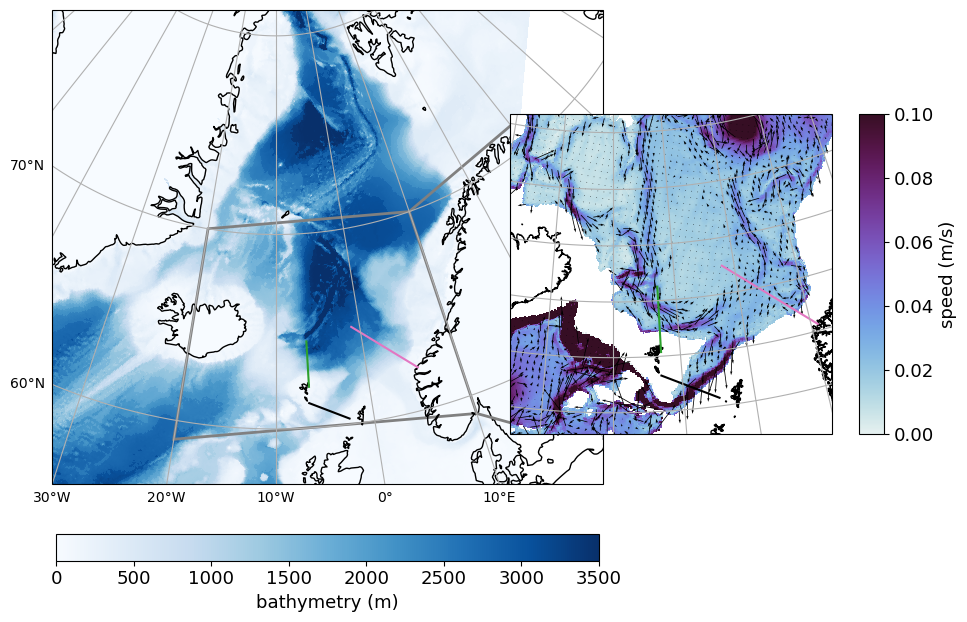

In [6]:
fig = plt.figure(figsize=(25, 8))

# Main figure (larger map)
ax_main = fig.add_subplot(
    1, 1, 1, projection=ccrs.Orthographic(central_longitude=-10, central_latitude=77)
)
# ax_main.set_extent([-40, 20, 55, 85], crs=ccrs.PlateCarree())
ax_main.set_extent([-30, 20, 55, 80], crs=ccrs.PlateCarree())


pcolormesh = ax_main.pcolormesh(
    mesh_mask.nav_lon,
    mesh_mask.nav_lat,
    bathy,
    cmap="Blues",
    vmin=0,
    vmax=3500,
    transform=ccrs.PlateCarree(),
)
cbar = plt.colorbar(
    pcolormesh, ax=ax_main, orientation="horizontal", pad=0.08, shrink=0.28
)
cbar.set_label("bathymetry (m)")
ax_main.coastlines()

gl = ax_main.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = plt.FixedLocator(np.arange(-180, 181, 10))
gl.ylocator = plt.FixedLocator(np.arange(-90, 91, 10))
gl.xlabel_style = {"size": 10}
gl.ylabel_style = {"size": 10}

rectangle = patches.Rectangle(
    (-20, 59),
    width=30,
    height=11,
    edgecolor="gray",
    facecolor="none",
    linewidth=2,
    transform=ccrs.PlateCarree(),
)
ax_main.add_patch(rectangle)

# sections
ax_main.plot(
    [5.5, -1],
    [62.24, 65.0],
    color="tab:pink",
    label="Svinoy section",
    transform=ccrs.PlateCarree(),
)
ax_main.plot(
    [-6.43, -6.43],
    [62.15, 64.5],
    color="tab:green",
    label="N section",
    transform=ccrs.PlateCarree(),
)
# ax_main.plot([-15, -11.95], [66.25, 68.7], color='blue', label='LN section', transform=ccrs.PlateCarree())
ax_main.plot([-6.5, -2.5], [61.3, 60.3], color="k", transform=ccrs.PlateCarree())


inset_ax = fig.add_axes(
    [0.45, 0.35, 0.4, 0.4],
    projection=ccrs.Orthographic(central_longitude=-10, central_latitude=77),
)
inset_ax.set_extent([-17, 5, 59, 70], crs=ccrs.PlateCarree())


pcolormesh = inset_ax.pcolormesh(
    select_data(mesh_mask.nav_lon),
    select_data(mesh_mask.nav_lat),
    mean_speed,
    cmap=cmocean.cm.dense,
    vmin=0,
    vmax=0.1,
    transform=ccrs.PlateCarree(),
)
inset_ax.coastlines()

cbar_inset_ax = fig.add_axes(
    [0.725, 0.35, 0.01, 0.4]
)  # Adjust the position and size as needed
cbar_inset = plt.colorbar(pcolormesh, cax=cbar_inset_ax)
cbar_inset.set_label("speed (m/s)")

inset_gl = inset_ax.gridlines(
    draw_labels=False, dms=True, x_inline=False, y_inline=False
)


inset_ax.plot([5.5, -1], [62.24, 65.0], color="tab:pink", transform=ccrs.PlateCarree())
inset_ax.plot(
    [-6.43, -6.43], [62.15, 64.5], color="tab:green", transform=ccrs.PlateCarree()
)
# inset_ax.plot([-15, -11.95], [66.25, 68.7], color='blue', transform=ccrs.PlateCarree())
inset_ax.plot([-6.5, -2.5], [61.3, 60.3], color="k", transform=ccrs.PlateCarree())


point_main1 = (10, 70)

point_inset1 = (32, 71.3)  # 40, 73.5

point_main2 = (10, 59)

point_inset2 = (13, 57.8)  # (15, 55.4)

ax_main.plot(
    [point_main1[0], point_inset1[0]],
    [point_main1[1], point_inset1[1]],
    "gray",
    linewidth=2,
    transform=ccrs.PlateCarree(),
)

ax_main.plot(
    [point_main2[0], point_inset2[0]],
    [point_main2[1], point_inset2[1]],
    "gray",
    linewidth=2,
    transform=ccrs.PlateCarree(),
)


# add U, V vectors
skip = 5
inset_ax.quiver(
    select_data(mesh_mask.nav_lon).values[::skip, ::skip],
    select_data(mesh_mask.nav_lat).values[::skip, ::skip],
    (mean_speed_mask * U_600_1300m_mean).values[::skip, ::skip],
    (mean_speed_mask * V_600_1300m_mean).values[::skip, ::skip],
    color="k",
    scale=1,
    transform=ccrs.PlateCarree(),
)

# plt.savefig('Fig1_bathy_sections.png', dpi=300,bbox_inches='tight')
plt.show()

## Figure 2

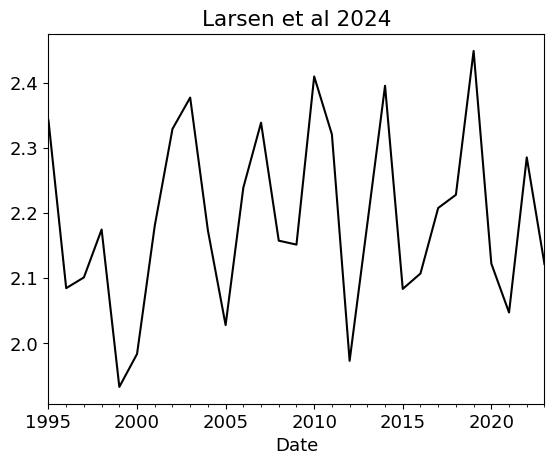

In [7]:
## add observations

inpth = "/gxfs_work/geomar/smomw452/GLORYS12/Data/observations/"
FBC_overflow_trspt = pd.read_csv(
    inpth + "FBC_overflow_transport.txt", delim_whitespace=True
)

Annual_FB_bottom_temp = pd.read_csv(
    inpth + "Annual_FB_bottom_temp.txt", delim_whitespace=True
)
Annual_FC_bottom_temp = pd.read_csv(
    inpth + "Annual_FC_bottom_temp.txt", delim_whitespace=True
)
Annual_S_section_salinity = pd.read_csv(inpth + "S06_S08_st.txt", delim_whitespace=True)


# convert decimal year to datetime
def decimal_year_to_datetime(decimal_year):
    year = int(decimal_year)
    fractional_year = decimal_year - year
    start_of_year = pd.Timestamp(f"{year}-01-01")
    days_in_year = 365
    days_passed = int(fractional_year * days_in_year)
    return start_of_year + pd.Timedelta(days=days_passed)


FBC_overflow_trspt["Date"] = FBC_overflow_trspt["Year"].apply(decimal_year_to_datetime)

FBC_overflow_trspt["Date"] = pd.to_datetime(FBC_overflow_trspt["Date"])


# setting date as the index
FBC_overflow_trspt.set_index("Date", inplace=True)
FBC_overflow_trspt_annual_means = FBC_overflow_trspt["Flux"].resample("Y").mean()
FBC_overflow_trspt_annual_means.plot(color="k")
plt.title("Larsen et al 2024")
plt.show()

cmap_vel = plt.get_cmap("bwr")
cmap_vel.set_bad(color="gray")

cmap_sal = plt.get_cmap("PuOr_r")
cmap_sal.set_bad(color="gray")


cmap_temp = plt.get_cmap("RdBu_r")
cmap_temp.set_bad(color="gray")

In [8]:
# load cross sections

S = xr.open_dataset(inpath + "S_section.nc")
S_sigma0 = (
    xr.apply_ufunc(
        sw.eos80.dens0,
        S.vosaline,
        S.votemper,
        dask="parallelized",
        output_dtypes=[np.float64],
    )
    - 1000
)
S_overflow = S.where(S_sigma0 > 28)

N = xr.open_dataset(inpath + "N_section.nc")
## density referenced to the surface
N_sigma0 = (
    xr.apply_ufunc(
        sw.eos80.dens0,
        N.vosaline,
        N.votemper,
        dask="parallelized",
        output_dtypes=[np.float64],
    )
    - 1000
)
N_overflow = N.where((N_sigma0 > 27.985))  # & (N_sigma0 < 28.02) 27.985

N_obs = xr.open_dataset(inpath + "GSR_FAROECURR_SSN_CTD_1m_1987_2023.nc")
N_obs_sigma0 = (
    xr.apply_ufunc(
        sw.eos80.dens0,
        N_obs.SAL,
        N_obs.TMP,
        dask="parallelized",
        output_dtypes=[np.float64],
    )
    - 1000
)
N_obs_overflow = N_obs.where((N_obs_sigma0 > 28))  # 28, 27.985

V = xr.open_dataset(inpath + "V_section.nc")
V_sigma0 = (
    xr.apply_ufunc(
        sw.eos80.dens0,
        V.vosaline,
        V.votemper,
        dask="parallelized",
        output_dtypes=[np.float64],
    )
    - 1000
)
V_overflow = V.where(V_sigma0 > 28)

In [9]:
S_trspt_detrend = detrend_dim(
    bl.calculate_transport(S.sel(z=slice(500, None)))
    .trsp.rolling(time_counter=12, center=True)
    .mean(),
    dim="time_counter",
)[1].sel(time_counter=slice("1996", "2019"))
V_trspt_detrend = detrend_dim(
    bl.calculate_transport(V.sel(z=slice(300, None)))
    .trsp.rolling(time_counter=12, center=True)
    .mean(),
    dim="time_counter",
)[1].sel(time_counter=slice("1996", "2019"))

In [10]:
plt.rcParams.update({"font.size": 14})

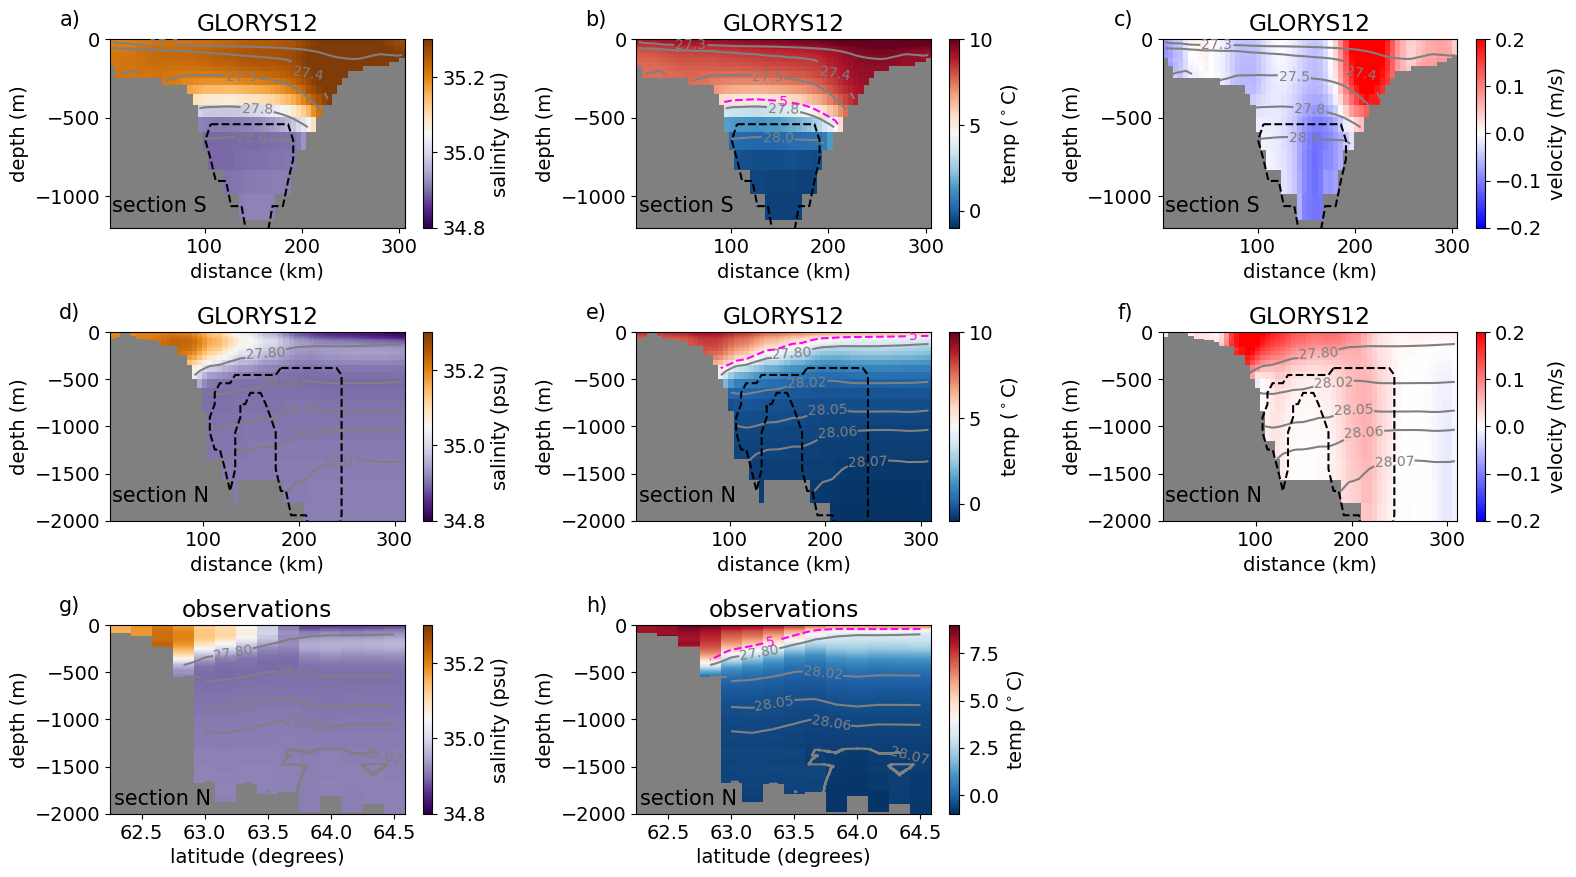

In [11]:
fig, axs = plt.subplots(3, 3, figsize=(16, 9))  # 3x3 grid

############################################
# Row 1: S section
############################################

# Salinity (row 1 col 0)
x = axs[0, 0].pcolormesh(
    S.c / 1e3,
    -S.z,
    S.vosaline.mean(dim="time_counter"),
    cmap=cmap_sal,
    vmin=34.8,
    vmax=35.3,
)
CS = axs[0, 0].contour(
    S.c / 1e3,
    -S.z,
    S_sigma0.mean(dim="time_counter"),
    [27.3, 27.4, 27.5, 27.8, 28.0],
    colors="gray",
)
axs[0, 0].clabel(CS, inline=True, fontsize=10)
axs[0, 0].set_ylim(-1200, 0)
axs[0, 0].set_xlabel("distance (km)")
axs[0, 0].set_ylabel("depth (m)")
# axs[0,0].text(30, -1000, 'Faroe', fontsize=15, color='k')
axs[0, 0].text(5, -1100, "section S", fontsize=15, color="k")
# axs[0,0].text(200, -1000, 'Shetland', fontsize=15, color='k')
cbar = plt.colorbar(x, ax=axs[0, 0])
axs[0, 0].set_title("GLORYS12")
cbar.set_label("salinity (psu)")
axs[0, 0].contour(
    S.c / 1e3,
    -S.z,
    xr.where(
        (
            (-S.u_rot_normal.mean(dim="time_counter") < 0)
            & (S_sigma0.mean(dim="time_counter") > 28)
        ),
        1,
        0,
    ),
    levels=0,
    colors="k",
    linestyles="dashed",
)

# temperature
x = axs[0, 1].pcolormesh(
    S.c / 1e3,
    -S.z,
    S.votemper.mean(dim="time_counter"),
    cmap=cmap_temp,
    vmin=-1,
    vmax=10,
)
CS = axs[0, 1].contour(
    S.c / 1e3,
    -S.z,
    S_sigma0.mean(dim="time_counter"),
    [27.3, 27.4, 27.5, 27.8, 28.0],
    colors="gray",
)
CS2 = axs[0, 1].contour(
    S.c / 1e3,
    -S.z,
    S.votemper.mean(dim="time_counter"),
    [5],
    colors="fuchsia",
    linestyles="dashed",
)
axs[0, 1].clabel(CS2, inline=True, fontsize=10)
axs[0, 1].clabel(CS, inline=True, fontsize=10)
axs[0, 1].set_ylim(-1200, 0)
axs[0, 1].set_xlabel("distance (km)")
axs[0, 1].text(5, -1100, "section S", fontsize=15, color="k")
# axs[0,1].text(200, -1000, 'Shetland', fontsize=15, color='k')
axs[0, 1].set_ylabel("depth (m)")
cbar = plt.colorbar(x, ax=axs[0, 1])
cbar.set_label(r"temp ($^\circ$C)")
axs[0, 1].set_title("GLORYS12")
axs[0, 1].contour(
    S.c / 1e3,
    -S.z,
    xr.where(
        (
            (-S.u_rot_normal.mean(dim="time_counter") < 0)
            & (S_sigma0.mean(dim="time_counter") > 28)
        ),
        1,
        0,
    ),
    levels=0,
    colors="k",
    linestyles="dashed",
)

# velocity
x = axs[0, 2].pcolormesh(
    S.c / 1e3,
    -S.z,
    -S.u_rot_normal.mean(dim="time_counter"),
    cmap=cmap_vel,
    vmin=-0.2,
    vmax=0.2,
)
CS = axs[0, 2].contour(
    S.c / 1e3,
    -S.z,
    S_sigma0.mean(dim="time_counter"),
    [27.3, 27.4, 27.5, 27.8, 28.0],
    colors="gray",
)
axs[0, 2].clabel(CS, inline=True, fontsize=10)
axs[0, 2].set_ylim(-1200, 0)
axs[0, 2].set_xlabel("distance (km)")
axs[0, 2].set_ylabel("depth (m)")
axs[0, 2].text(
    5, -1100, "section S", fontsize=15, color="k"
)  # .text(30, -1000, 'Faroe', fontsize=15, color='k')
# axs[0,2].text(200, -1000, 'Shetland', fontsize=15, color='k')
cbar = plt.colorbar(x, ax=axs[0, 2])
cbar.set_label("velocity (m/s)")
axs[0, 2].set_title("GLORYS12")
axs[0, 2].contour(
    S.c / 1e3,
    -S.z,
    xr.where(
        (
            (-S.u_rot_normal.mean(dim="time_counter") < 0)
            & (S_sigma0.mean(dim="time_counter") > 28)
        ),
        1,
        0,
    ),
    levels=0,
    colors="k",
    linestyles="dashed",
)

############################################
# Row 2: N section
############################################

# Salinity (row 2 col 0)
x = axs[1, 0].pcolormesh(
    N.c / 1e3,
    -N.z,
    N.vosaline.mean(dim="time_counter"),
    cmap=cmap_sal,
    vmin=34.8,
    vmax=35.3,
)
CS = axs[1, 0].contour(
    N.c / 1e3,
    -N.z,
    N_sigma0.mean(dim="time_counter"),
    [27.8, 28.02, 28.05, 28.06, 28.07, 28.08],
    colors="gray",
)
axs[1, 0].clabel(CS, inline=True, fontsize=10)
axs[1, 0].text(5, -1800, "section N", fontsize=15, color="k")
axs[1, 0].set_ylim(-2000, 0)
axs[1, 0].set_xlabel("distance (km)")
axs[1, 0].set_ylabel("depth (m)")
cbar = plt.colorbar(x, ax=axs[1, 0])
cbar.set_label("salinity (psu)")
axs[1, 0].set_title("GLORYS12")
axs[1, 0].contour(
    N.c / 1e3,
    -N.z,
    xr.where(
        (
            (N.u_rot_normal.mean(dim="time_counter") > 0.01)
            & (N_sigma0.mean(dim="time_counter") > 28)
        ),
        1,
        0,
    ),
    levels=0,
    colors="k",
    linestyles="dashed",
)


# temperature
x = axs[1, 1].pcolormesh(
    N.c / 1e3,
    -N.z,
    N.votemper.mean(dim="time_counter"),
    cmap=cmap_temp,
    vmin=-1,
    vmax=10,
)
CS = axs[1, 1].contour(
    N.c / 1e3,
    -N.z,
    N_sigma0.mean(dim="time_counter"),
    [27.8, 28.02, 28.05, 28.06, 28.07, 28.08],
    colors="gray",
)
CS2 = axs[1, 1].contour(
    N.c / 1e3,
    -N.z,
    N.votemper.mean(dim="time_counter"),
    [5],
    colors="fuchsia",
    linestyles="dashed",
)
axs[1, 1].clabel(CS2, inline=True, fontsize=10)
axs[1, 1].clabel(CS, inline=True, fontsize=10)
axs[1, 1].text(5, -1800, "section N", fontsize=15, color="k")
axs[1, 1].set_ylim(-2000, 0)
axs[1, 1].set_xlabel("distance (km)")
axs[1, 1].set_ylabel("depth (m)")
cbar = plt.colorbar(x, ax=axs[1, 1])
cbar.set_label(r"temp ($^\circ$C)")
axs[1, 1].set_title("GLORYS12")
axs[1, 1].contour(
    N.c / 1e3,
    -N.z,
    xr.where(
        (
            (N.u_rot_normal.mean(dim="time_counter") > 0.01)
            & (N_sigma0.mean(dim="time_counter") > 28)
        ),
        1,
        0,
    ),
    levels=0,
    colors="k",
    linestyles="dashed",
)

# velocity
x = axs[1, 2].pcolormesh(
    N.c / 1e3,
    -N.z,
    N.u_rot_normal.mean(dim="time_counter"),
    cmap=cmap_vel,
    vmin=-0.2,
    vmax=0.2,
)
CS = axs[1, 2].contour(
    N.c / 1e3,
    -N.z,
    N_sigma0.mean(dim="time_counter"),
    [27.8, 28.02, 28.05, 28.06, 28.07, 28.08],
    colors="gray",
)
axs[1, 2].clabel(CS, inline=True, fontsize=10)
axs[1, 2].text(5, -1800, "section N", fontsize=15, color="k")
axs[1, 2].set_ylim(-2000, 0)
axs[1, 2].set_xlabel("distance (km)")
axs[1, 2].set_ylabel("depth (m)")
cbar = plt.colorbar(x, ax=axs[1, 2])
cbar.set_label("velocity (m/s)")
axs[1, 2].set_title("GLORYS12")
axs[1, 2].contour(
    N.c / 1e3,
    -N.z,
    xr.where(
        (
            (N.u_rot_normal.mean(dim="time_counter") > 0.01)
            & (N_sigma0.mean(dim="time_counter") > 28)
        ),
        1,
        0,
    ),
    levels=0,
    colors="k",
    linestyles="dashed",
)

############################################
# Row 3: Observations
############################################

# salinity
x = axs[2, 0].pcolormesh(
    N_obs.LATITUDE,
    -N_obs.DEPTH,
    N_obs.SAL.T.mean(dim="TIME"),
    cmap=cmap_sal,
    vmin=34.8,
    vmax=35.3,
)
CS = axs[2, 0].contour(
    N_obs.LATITUDE,
    -N_obs.DEPTH,
    N_obs_sigma0.T.mean(dim="TIME"),
    [27.8, 28.02, 28.05, 28.06, 28.07],
    colors="gray",
)
axs[2, 0].clabel(CS, inline=True, fontsize=10)
axs[2, 0].text(62.28, -1900, "section N", fontsize=15, color="k")
axs[2, 0].set_ylim(-2000, 0)
axs[2, 0].set_xlabel(r"latitude (degrees)")
axs[2, 0].set_ylabel("depth (m)")
axs[2, 0].set_title("observations")
cbar = plt.colorbar(x, ax=axs[2, 0])
cbar.set_label("salinity (psu)")

# temp
x = axs[2, 1].pcolormesh(
    N_obs.LATITUDE,
    -N_obs.DEPTH,
    N_obs.TMP.T.mean(dim="TIME"),
    cmap=cmap_temp,
    vmin=-1,
    vmax=9,
)
CS = axs[2, 1].contour(
    N_obs.LATITUDE,
    -N_obs.DEPTH,
    N_obs_sigma0.T.mean(dim="TIME"),
    [27.8, 28.02, 28.05, 28.06, 28.07],
    colors="gray",
)
CS2 = axs[2, 1].contour(
    N_obs.LATITUDE,
    -N_obs.DEPTH,
    N_obs.TMP.T.mean(dim="TIME"),
    [5],
    colors="fuchsia",
    linestyles="dashed",
)
axs[2, 1].text(62.28, -1900, "section N", fontsize=15, color="k")
axs[2, 1].clabel(CS2, inline=True, fontsize=10)
axs[2, 1].clabel(CS, inline=True, fontsize=10)
axs[2, 1].set_ylim(-2000, 0)
axs[2, 1].set_xlabel(r"latitude (degrees)")
axs[2, 1].set_ylabel("depth (m)")
axs[2, 1].set_title("observations")
cbar = plt.colorbar(x, ax=axs[2, 1])
cbar.set_label(r"temp ($^\circ$C)")

# make empty plot
axs[2, 2].axis("off")


labels = [f"{letter})" for letter in string.ascii_lowercase[:8]]


for i, ax in enumerate(axs.flat[:-1]):
    ax.text(
        -0.1,
        1.05,
        f"{labels[i]}",
        transform=ax.transAxes,
        fontsize=15,
        va="bottom",
        ha="right",
    )

plt.tight_layout()
# plt.savefig('Fig2_S_N_section_obs.png', dpi=300, bbox_inches='tight')
plt.show()

In [12]:
def weighted_mean(data):
    # mask = xr.where(data.u_normal > 0,1,np.nan)
    gb_area = data.dx * data.dz  # mask* mask*
    numerator = (
        (data * gb_area).squeeze().sum(["z", "c"])
    )  # if want to depth average over range of depths, use native grid! .isel(z=slice...).then sum over z, y, and x
    denominator = (gb_area).sum(["c", "z"]).squeeze()
    div = numerator / denominator
    return div


convert_abSal_psu = 1.0047154

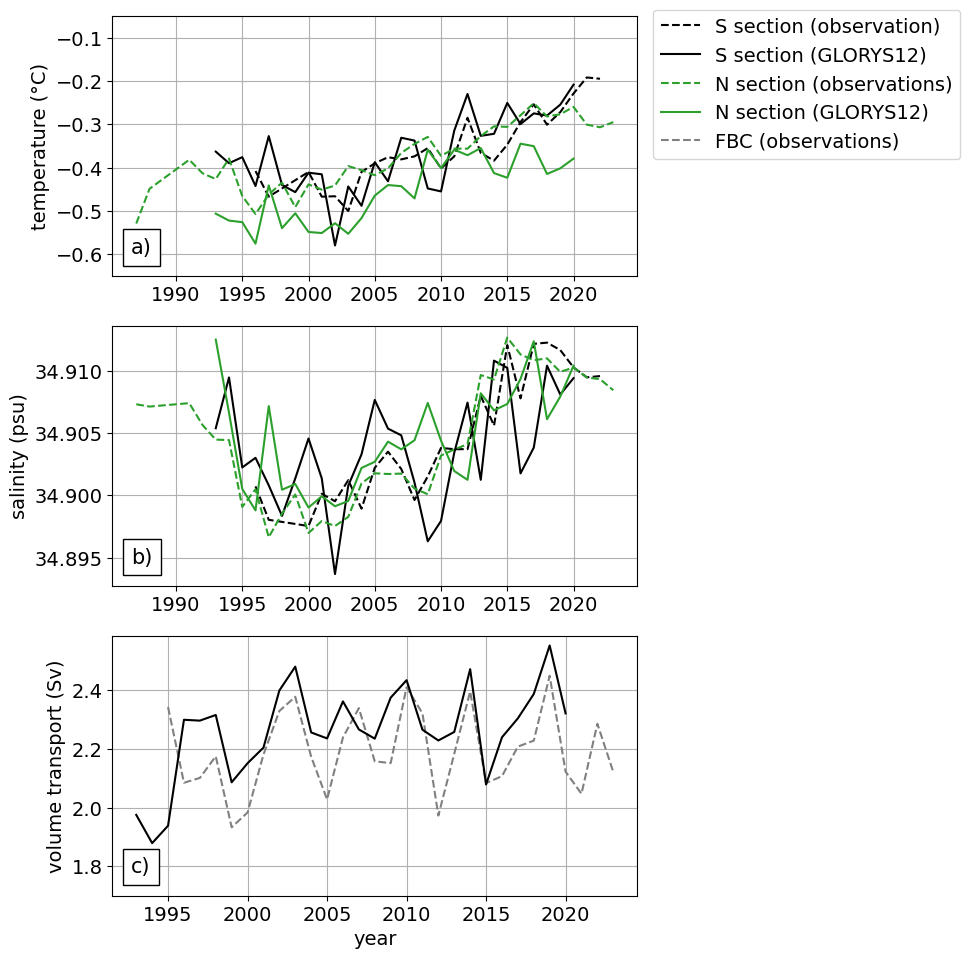

In [14]:
fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=False)

# --------- Plot 1: Temperature time series ---------
axs[0].plot(
    Annual_FB_bottom_temp["Year"],
    Annual_FB_bottom_temp["Tcom"],
    color="k",
    linestyle="dashed",
    label="S section (observation)",
)
axs[0].plot(
    np.arange(1993, 2021, 1),
    weighted_mean(S_overflow)
    .votemper.groupby("time_counter.year")
    .mean(dim="time_counter"),
    label="S section (GLORYS12)",
    color="k",
)
axs[0].plot(
    N_obs_overflow.mean(dim=("STATION", "DEPTH"))
    .TMP.groupby("TIME.year")
    .mean(dim="TIME")
    .year,
    N_obs_overflow.mean(dim=("STATION", "DEPTH"))
    .TMP.groupby("TIME.year")
    .mean(dim="TIME"),
    color="tab:green",
    linestyle="dashed",
    label="N section (observations)",
)
axs[0].plot(
    np.arange(1993, 2021, 1),
    weighted_mean(N_overflow)
    .votemper.groupby("time_counter.year")
    .mean(dim="time_counter"),
    color="tab:green",
    label="N section (GLORYS12)",
)
axs[0].plot(
    np.arange(1995, 2024, 1),
    FBC_overflow_trspt_annual_means * 1000,
    color="gray",
    linestyle="dashed",
    label="FBC (observations)",
)
axs[0].legend(loc=(1.03, 0.45))
axs[0].grid()
axs[0].set_ylabel("temperature (°C)")
axs[0].set_ylim(-0.65, -0.05)
axs[0].add_artist(
    AnchoredText("a)", prop=dict(size=15), frameon=True, loc="lower left")
)

# --------- Plot 2: Salinity time series ---------
axs[1].plot(
    Annual_S_section_salinity["Year"],
    Annual_S_section_salinity["Avg"] / convert_abSal_psu,
    color="k",
    linestyle="dashed",
    label="S section (observations)",
)
axs[1].plot(
    np.arange(1993, 2021, 1),
    weighted_mean(S_overflow)
    .vosaline.groupby("time_counter.year")
    .mean(dim="time_counter"),
    color="k",
    label="S section (GLORYS12)",
)
axs[1].plot(
    N_obs_overflow.mean(dim=("STATION", "DEPTH"))
    .SAL.groupby("TIME.year")
    .mean(dim="TIME")
    .year,
    N_obs_overflow.mean(dim=("STATION", "DEPTH"))
    .SAL.groupby("TIME.year")
    .mean(dim="TIME"),
    color="tab:green",
    linestyle="dashed",
    label="N section (observations)",
)
axs[1].plot(
    np.arange(1993, 2021, 1),
    weighted_mean(N_overflow)
    .vosaline.groupby("time_counter.year")
    .mean(dim="time_counter"),
    color="tab:green",
    label="N section (GLORYS12)",
)
axs[1].grid()
axs[1].set_ylabel("salinity (psu)")
axs[1].add_artist(
    AnchoredText("b)", prop=dict(size=15), frameon=True, loc="lower left")
)

# --------- Plot 3: Volume transport time series ---------
axs[2].plot(
    np.arange(1995, 2024, 1),
    FBC_overflow_trspt_annual_means,
    color="gray",
    linestyle="dashed",
    label="FBC",
)
axs[2].plot(
    np.arange(1993, 2021, 1),
    bl.calculate_transport(S.sel(z=slice(500, None)))
    .trsp.groupby("time_counter.year")
    .mean(dim="time_counter"),
    color="k",
)
axs[2].grid()
axs[2].set_ylabel("volume transport (Sv)")
axs[2].set_ylim(1.7, None)
axs[2].add_artist(
    AnchoredText("c)", prop=dict(size=15), frameon=True, loc="lower left")
)

# Adjust layout
plt.xlabel("year")
plt.tight_layout()
# plt.savefig('Fig3_S_N_section_ts.png', dpi=300, bbox_inches='tight')
plt.show()